<a href="https://colab.research.google.com/github/gitansha/manufacturing-optimization-ui/blob/main/AMEX%20ml%20model%20for%20loan%20defaulter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Exercise

## Prerequisite + how to use this notebook
- You do not need any data science/machine learning experience.
- You do not need any finance/banking/credit-related knowledge.
- Ability to read/write Python code is preferable. Pro-tip: Make a coder friend and buy them coffee later.
- All the hands-on portions will be you writing a function to perform a certain task. Feel free to ask your facilitators if you need help.

## Preface

In problem solving, a common mantra is **Garbage-In-Garbage-Out**. It implies that if the input to our problem is of poor quality, then any solution effort or output will be rendered meaningless.

More concretely in modern data science practice, it reminds us to carefully consider the data that we use, before we even speak of fancy models. Indeed, one of the main reasons American Express models thrive is precisely the effort we put into curating our training data. Some key steps include:

- Understanding the quality of our data sources
- Analysing the statistics of our data to facilitate pre-processing
- Anticipate changes in data trends over time
- Leverage business insights to manipulate raw data to maximise information gain

In this session, will focus on the last point. Given thousands upon thousands of raw data, one of the crucial responsibility of an American Express data scientist is to leverage both technical skills and business accumen to spot opportunities where we can generate useful modeling variables -- we are talking about **feature engineering**.

Unfortunately, you will not see any Amex data today. Instead, we will leverage a publicly available [credit risk dataset](https://www.kaggle.com/c/home-credit-default-risk/) from Kaggle for our example problem. We will first explore the dataset to have some understanding of what it can do for us, then you will have a taste of how to generate some interesting features, which we then test in a simple model.

For simplicity, we only use a small subset of the full Kaggle data. Further, for your convenience, we have cleaned the data ahead of time. You need not worry about the other troubles of data engineering (there are many, trust me).

Today, your sole focus is to **think** like a data scientist.

# Download dataset

In [ ]:
from google.colab import auth
auth.authenticate_user()

!curl https://sdk.cloud.google.com | bash > output_log

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   443  100   443    0     0   5425      0 --:--:-- --:--:-- --:--:--  5469
############################################################################################# 100.0%
which curl
curl -# -f https://dl.google.com/dl/cloudsdk/channels/rapid/google-cloud-sdk.tar.gz
############################################################################################# 100.0%
mkdir -p /root
tar -C /root -zxvf /tmp/tmp.No6Uz6rEAP/google-cloud-sdk.tar.gz
/root/google-cloud-sdk/install.sh
Beginning update. This process may take several minutes.


Your current Google Cloud CLI version is: 496.0.0
Installing components from version: 496.0.0

┌─────────────────────────────────────────────────────────────────────────────┐
│                     These components will be installed.                     │
├───────────────────────────────────────

In [ ]:
# You will be asked for a configuration, enter '2'.
# Then, enter any configuration name you like, does not matter.
# Then, enter '3' to skip the next step.
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
core:
  account: shahnisargshah@gmail.com

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  2

Enter configuration name. Names start with a lower case letter and contain only 
lower case letters a-z, digits 0-9, and hyphens '-':  wereuyt
Your current configuration has been set to: [wereuyt]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you want to use for this configuration.
To use a federated user account, exit this command and sign in to the gcloud CLI
 with your login configuration f

In [ ]:
! mkdir data

In [ ]:
!gsutil cp gs://home-credit-data/HomeCredit_columns_description.csv ./data/

Copying gs://home-credit-data/HomeCredit_columns_description.csv...
/ [1 files][ 36.5 KiB/ 36.5 KiB]                                                
Operation completed over 1 objects/36.5 KiB.                                     


In [ ]:
!gsutil cp gs://home-credit-data/onemil_bureau.csv ./data/
!gsutil cp gs://home-credit-data/onefiftyk_application_train.csv ./data/
!gsutil cp gs://home-credit-data/fourk_previous_application.csv ./data/

Copying gs://home-credit-data/onemil_bureau.csv...
| [1 files][ 94.5 MiB/ 94.5 MiB]                                                
Operation completed over 1 objects/94.5 MiB.                                     
Copying gs://home-credit-data/onefiftyk_application_train.csv...
- [1 files][ 77.3 MiB/ 77.3 MiB]                                                
Operation completed over 1 objects/77.3 MiB.                                     
Copying gs://home-credit-data/fourk_previous_application.csv...
| [1 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 1 objects/92.8 MiB.                                     


# Load necessary libraries

In [ ]:
import xgboost as xgb # for model training
import numpy as np # for numerical calculations
import matplotlib.pyplot as plt # for visualisations
import pandas as pd # for general tabular data manipulation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from sklearn.metrics import roc_auc_score # for model evaluation
import functools # for functools.reduce for cleaner code
data_dictionary_full = pd.read_csv('data/HomeCredit_columns_description.csv', encoding='unicode_escape') # table definitions

# Problem statement: Predicting Home Credit default risk

When someone borrows money and does not pay back (within a specified time), we call that a **default**. In risk modeling, a common goal is to predict the probability of default of a loan application.

To do so, we are given a dataset which contains historical records of various loan applications and whether or not the customers pay back. We then pick a model that we think can do a good job at understanding this data. The model then 'studies' these data to extract and store the information that distinguish between good loans vs. bad loans (eventual defaults). Theses information are stored numerically as the model's **parameters**. Overall, the process of optimizing the parameters of a model with respect to a dataset is called model **training**.

Then, the next time a new loan application comes along, our model processes the application details and then outputs a number between 0 and 1, which defines our predicted probability of default. Naturally, if we predict that the probability of default is high, then we may prefer to reject that loan application. In all, the model helps the company control the level of risk they wouldl like in their portfolio.

# Main data: loan applications

The data we have is tabular, which just means that we can interpret it as a spreadsheet/table (as opposed to text data, or image data). In particular, we are given 9,999 data points/rows, each row representing a loan application. For each row, we have many columns:
- Index variable: 'SK_ID_CURR'. We use this to ID the application.
- Dependent variable (also called label or target): 'TARGET'. Default = 1, no default = 0. We say that this is a 'binary outcome'.
- Independent variables: All others columns. We will use these information to predict the dependent variable.

In [ ]:
# Unique ID code for each loan application / data row
index_variable = 'SK_ID_CURR'

# True label of the prediction problem
dependent_variable = 'TARGET'

# The columns that we use to predict the label, there are many, let's just use these 10.
independent_variables = [
    'EXT_SOURCE_1',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'DAYS_EMPLOYED',
    'AMT_GOODS_PRICE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'NONLIVINGAPARTMENTS_AVG',
    'AMT_REQ_CREDIT_BUREAU_QRT'
]

# Load data (just the above columns)
data = pd.read_csv('data/onefiftyk_application_train.csv',
            usecols=[index_variable, dependent_variable] + independent_variables)

# Let's just take top 9999 rows for a smaller dataset
data = data.head(9999)

# Shuffle rows is a good practice
data = data.sample(frac=1., random_state=20241009)
print(len(data))

9999


We can take quick glance at our data.

In [ ]:
# Display top 10 rows
data.head(10)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,EXT_SOURCE_1,NONLIVINGAPARTMENTS_AVG,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_QRT
3787,104427,0,225000.0,225000.0,15219.0,225000.0,-4445,0.516483,NaN,0.0,0.0,1.0
2634,103074,0,337500.0,497520.0,36054.0,450000.0,-4491,0.491551,NaN,0.0,0.0,0.0
238,100276,0,135000.0,497520.0,39438.0,450000.0,-1787,0.531800,0.0039,0.0,2.0,0.0
5752,106726,0,108000.0,446931.0,21865.5,369000.0,-2019,NaN,NaN,0.0,0.0,NaN
8670,110092,0,112500.0,277969.5,20272.5,229500.0,-552,NaN,NaN,1.0,1.0,0.0
6287,107338,0,315000.0,1345036.5,39456.0,1174500.0,-4680,0.608168,0.0039,0.0,13.0,0.0
1040,101207,0,76500.0,545040.0,19575.0,450000.0,-481,0.559085,NaN,0.0,0.0,0.0
2330,102727,0,270000.0,539100.0,27522.0,450000.0,-2752,0.322696,NaN,0.0,4.0,0.0
9329,110846,0,112500.0,127350.0,13176.0,112500.0,-3713,0.798985,NaN,0.0,3.0,NaN
8147,109500,0,202500.0,1530000.0,62446.5,1530000.0,365243,0.795519,NaN,0.0,1.0,1.0



Here are the definitions of the independent variables

In [ ]:
def column_descriptions(d):
    '''Enter a dataframe and outcomes the column definitions'''
    data_cols = pd.DataFrame({'Row':d.columns})
    return data_dictionary_full[['Row', 'Description']].merge(data_cols, on='Row', how='inner').drop_duplicates('Row')

In [ ]:
column_descriptions(data)

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,AMT_INCOME_TOTAL,Income of the client
3,AMT_CREDIT,Credit amount of the loan
4,AMT_ANNUITY,Loan annuity
5,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given
6,DAYS_EMPLOYED,How many days before the application the person started current employment
7,EXT_SOURCE_1,Normalized score from external data source
8,NONLIVINGAPARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
9,DEF_30_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings defaulted on 30 DPD (days past due)


# Basic data exploration

Let's start with understanding what are the proportion of defaults in our data.

In [ ]:
# Total number of defaults, and default rate as a ratio
data[dependent_variable].sum(), data[dependent_variable].mean()

(775, 0.0775077507750775)

It seems that our data has a default rate of ~7.8%. Immediately, this tells us that our data is imbalanced, i.e. most applications are good, only few are bad.

You might ask, so what? For one, this means that our model only has some 700+ default examples during training, while it can draw from 9.2k+ good loan applications. We should expect the model to learn the two classes to different degrees of effectiveness.

More importantly, suppose we have a trivial model that always predicts 0 (no default). Even though this model is clearly 'wrong', it will be correct about 92% of the time, which does sound like a good score! The key insight is that when dealing with datasets with imbalanced classes, we should be careful about how we measure model performance. In this case, percentage of correct predictions even though is a natural notion, is in fact highly flawed. We will consider a more sophisticated metric later.

# Histograms
We shall plot the histogram of each independent variable to get a sense of the data range and distributions. The plots show normalized densities, e.g. they sum up to 1. To show the absolute occurences/frequencies, change relevant plotting function argument to `density=False`.

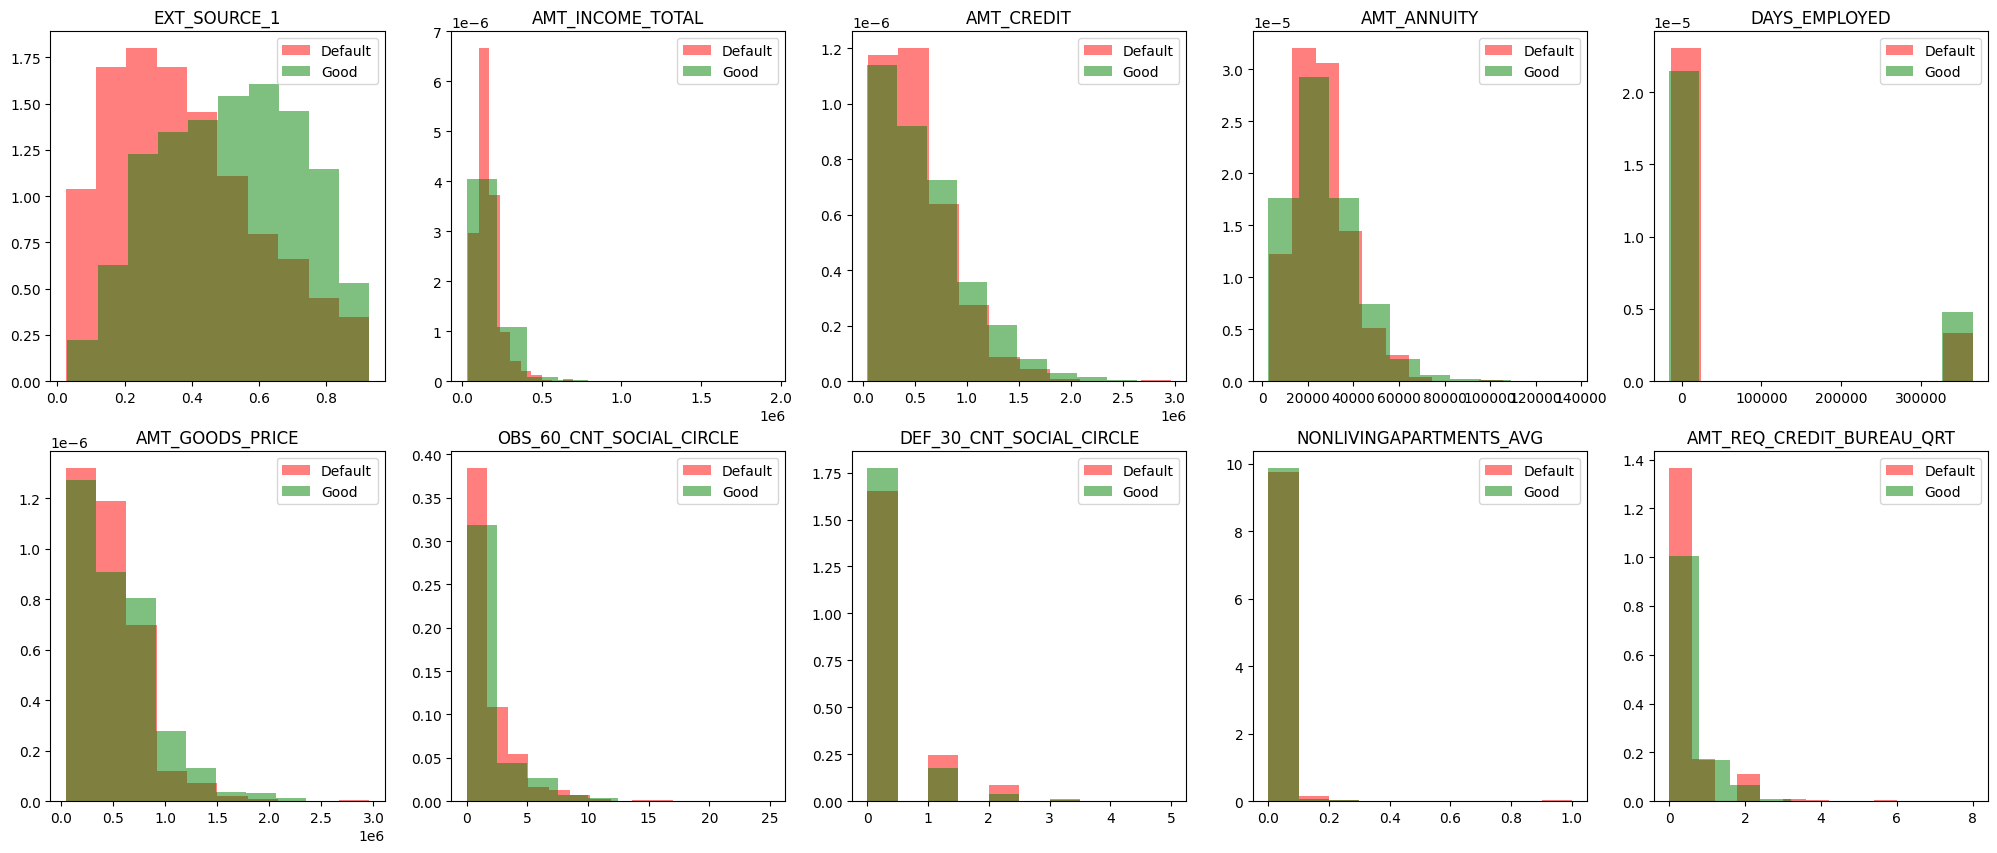

In [ ]:
ncols=5
fig, axes = plt.subplots(nrows=len(independent_variables)//ncols, ncols=ncols, figsize=(25,10))

for i, v in enumerate(independent_variables):
    row = i // ncols
    col = i % ncols
    axes[row,col].hist(data[data[dependent_variable]==1][v],bins=10, alpha=0.5, color='r', density=True, label='Default');
    axes[row,col].hist(data[data[dependent_variable]==0][v],bins=10, alpha=0.5, color='g', density=True, label='Good');
    axes[row,col].set_title(v)
    axes[row,col].legend();

# Training a model

The goal is to use the independent variables to predict the dependent variable for each loan (identified by the index). We shall use the [XGboost](https://xgboost.readthedocs.io/en/stable/) model, which is widely successful and therefore a popular choice when it comes to learning from tabular data. In this exercise, it is sufficient to treat the XGBoost model as a black box.

## Model training 101:
- To train a model is to find model parameters that can minimize a certain loss function. We use the **cross-entropy loss**, which is the common choice of binary classification. Intuitively, this loss will be high when the predicted probability is far from the label. E.g. label=1 and prediction=0.95 gives low loss; label=1 and prediction=0.05 leads to high loss. A strong model is one that produces low losses overall. Indeed, different loss functions lead to different final parameters.

- The mathematical search for optimal parameters that minimize the loss function is achieved through optimization techniques. Most frequently, we use a version of the **gradient descent** method.

- We do not train our model with 100% of the data we have, the **train set** here is set to 60% of the data. For the remaining 40%, we split them further into two. 20% will serve as the **validation set** that is used to tell us when we should stop training and overfitting start to occur. The last 20% is simply the **test set** on which we report the final result. A simple analogy: it is a bad idea to set an exam using only questions directly taken from past exams. Students may just memorise the past answers, get a high score, but learn nothing about the subject. We say that a **data leak** occurs when we mistaken let our model be influenced by the test set. This happens very easily in fact, can you come up with one example?

In [ ]:
# Split the data into test, train, and validation sets
train_ratio = 0.6 # 60% train set
val_ratio = 0.2 # 20% validation, the rest goes to test set
n_train = int(train_ratio * len(data)) # number of train datapoints
n_val = int(val_ratio * len(data)) # number of validation datapoints

In [ ]:
def train_gbm(dtrain, dval,
             ):
    '''trains a GBM model, observe loss on test and train sets'''
    watchlist = [(dtrain, 'train'), (dval, 'eval')] # early stopping is applied to the validation set

    # We fix these hyperparameters
    num_round=30 # number of boosted trees
    # depth, learning rate, and others
    param={"max_depth": 3, "eta": 0.25, "gamma":1., "verbosity":1, "objective": "binary:logistic"}

    # Train an XGB model using the specified hyperparameters, with early stopping round set to 1 (should be higer in real-life)
    model = xgb.train(param, dtrain, num_boost_round=num_round, evals=watchlist, early_stopping_rounds=1)

    return model

def train_and_score(data, index_variable=index_variable, dependent_variable=dependent_variable, n_train=n_train):

    # predictor columns
    independent_variables = set(data.columns) - set([index_variable, dependent_variable])
    independent_variables = list(independent_variables)

    # predictor matrix
    data_x = data[independent_variables]

    # label matrix
    data_y = data[[dependent_variable]]

    # convert data into DMatrix format, readable by XGB algorithm
    dtrain = xgb.DMatrix(data_x[:n_train],data_y[:n_train])
    dval = xgb.DMatrix(data_x[n_train:n_train+n_val],data_y[n_train:n_train+n_val])
    dtest = xgb.DMatrix(data_x[n_train + n_val:],data_y[n_train + n_val:])
    trained_model = train_gbm(dtrain, dval)

    # True label
    label = dtest.get_label()

    # Predicted probabilities
    prob = trained_model.predict(dtest)

    # Output the train model, true label, and predited probabilities
    return trained_model, label, prob

In [ ]:
trained_model, label, prob = train_and_score(data)

[0]	train-logloss:0.28157	eval-logloss:0.28388
[1]	train-logloss:0.27167	eval-logloss:0.27665
[2]	train-logloss:0.26445	eval-logloss:0.27187
[3]	train-logloss:0.25909	eval-logloss:0.26823
[4]	train-logloss:0.25551	eval-logloss:0.26625
[5]	train-logloss:0.25186	eval-logloss:0.26418
[6]	train-logloss:0.24903	eval-logloss:0.26289
[7]	train-logloss:0.24737	eval-logloss:0.26259
[8]	train-logloss:0.24567	eval-logloss:0.26180
[9]	train-logloss:0.24388	eval-logloss:0.26195


We observe that the training losses reduces as we further train the model.

When should we stop training? Intuitively, we can keep increasing the optimization iterations and we may always find better results. In practice, we commonly stop when the train set results stop improving significantly.

Furthermore, we apply a technique called **early-stopping**, this means we train on the train set whilst observing the loss on the validation test. Once the validation set stops improving, we conclude the training. The intuition is that if we keep on focusing on improving loss on the train set, the model will **overfit** to the train set and is unable to generalize to unseen examples.

Note that in practice, it is often useful to spend some time to fine-tune the model hyperparameters to further reduce the training error.

# Evaluating the model

To measure model performance, we consider the **receiver operating characteristic (ROC)** curve. The ROC curve is a plot of the true positive rate against the false positive rate. Relating this back to our imbalanced dataset, a trivial model that always predicts 0 will give a fantastic zero false positive rate, but sadly also it gives us zero true positive rate. The trade-off between these two quantities is how we fairly evaluate our trained model.

In [ ]:
def true_positive_rate(prob, label, threshold):
    '''
    E.g. if we set threshold to 0.3, then when predicted probabilities > 0.3
    we will predict the loan to default. Else, it does not default. This gives us
    a list of 1/0 predictions.

    TPR = Total positive predictions that are correct / Total positive labels
    '''

    pred = (prob > threshold).astype(int)
    true_positive = sum((pred == 1) & (label == 1))
    false_negative = sum((pred == 0) & (label == 1))
    return true_positive / (true_positive + false_negative)

def false_positive_rate(prob, label, threshold):

    '''
    E.g. if we set threshold to 0.3, then when predicted probabilities > 0.3
    we will predict the loan to default. Else, it does not default. This gives us
    a list of 1/0 predictions.

    TPR = Total positive predictions that are wrong / Total negative labels
    '''

    pred = (prob > threshold).astype(int)
    false_positive = sum((pred == 1) & (label == 0))
    true_negative = sum((pred == 0) & (label == 0))
    return false_positive / (true_negative + false_positive)

def roc(label, prob, n_points=20):
    '''
    Plot of TPR (y-axis) vs FPR (x-axis)

    At every threshold, we can calculate TPR and FPR, which gives us a point on the ROC.
    Do this for many thresholds, we get a curve.
    '''
    ordering = np.argsort(prob)
    prob = prob[ordering]
    label = label[ordering]
    thresholds = np.quantile(prob, q=np.linspace(0,1,n_points))

    # Output list of FPR and TPR
    return ([false_positive_rate(prob,label,threshold=threshold_) for threshold_ in thresholds],
            [true_positive_rate(prob,label,threshold=threshold_) for threshold_ in thresholds])

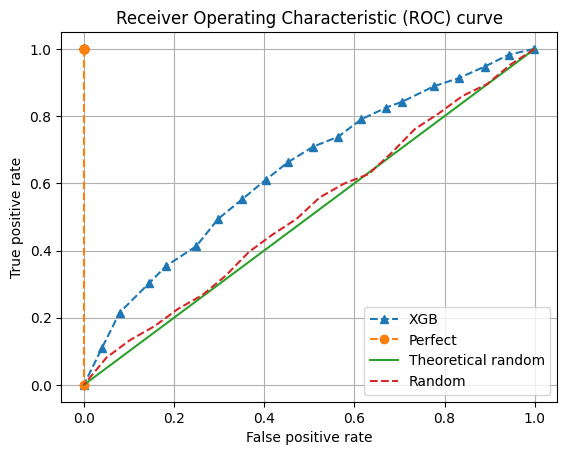

In [ ]:
# Plot ROC
plt.figure()
plt.plot(*roc(label, prob), '^--', label='XGB')
plt.plot(*roc(label, label), 'o--', label='Perfect')
plt.plot([0,1], [0,1], '-', label='Theoretical random')
random_guess = np.random.uniform(0,1,len(label))
plt.plot(*roc(label, random_guess), '--', label='Random')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.grid('both')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend();

From the ROC curve, we calculate the **area under the ROC curve (AUC)** as our evaluation metric.

A model with perfect predictions will give an AUC score of 1 and random-guessing predictions will give an AUC of 0.5. Overall, the ROC of a trained model lies between the perfect model and the random model.

In [ ]:
# Calculate the ROC AUC score
print(f"ROC AUC Score: {roc_auc_score(label, prob):.3f}")

ROC AUC Score: 0.641


# Feature engineering: combining features to get new ones

Our starting model is decent. However, we may not always rely on the model training to extract every bit of information embedded within our data. We should use our business insights to enhance our data.

Looking at our data, we have **amt_credit** and **amt_annuity**. They represent the total amount we loan the customer and the monthly repayment amount respectively. Notice that simply considering the annuity amount lacks context, e.g. is \$1,000 monthly payment high or low?

Ans: It depends on the total amount! A \$1,000 annuity is very high if the total loan is \$2,000 (2 months payback in full), as opposed to a \$1,000 annunity on a \$10 million loan.

Therefore, it seems useful to create a variable that expresses the annuity as a proportion of the total loan amount.

Let us create this feature and call it the **payment rate**.

# Payment rate

In [ ]:
# HANDS-ON
def create_ratio(amt_annuity, amt_credit):
  '''What is the relationship we are looking for if we want to quantify
  the annuity as a proportion of total credit?'''

  return amt_annuity/amt_credit # Answer

In [ ]:
data_2 = data.copy(deep=True)
data_2['NEW_PAYMENT_RATE'] = create_ratio(data_2['AMT_ANNUITY'], data_2['AMT_CREDIT'])

Let us visualise this new variable in a normalized histogram.

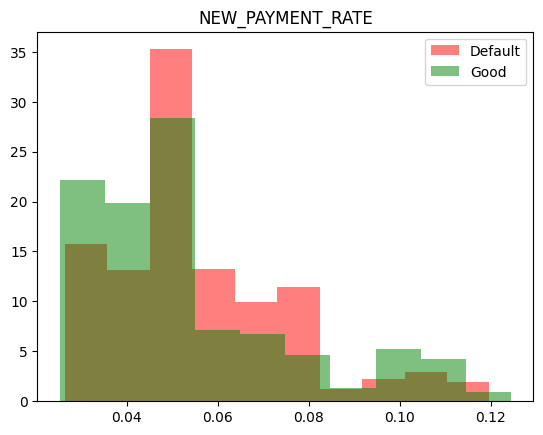

In [ ]:
plt.hist(data_2[data_2[dependent_variable]==1]['NEW_PAYMENT_RATE'],bins=10, alpha=0.5, color='r', density=True, label='Default');
plt.hist(data_2[data_2[dependent_variable]==0]['NEW_PAYMENT_RATE'],bins=10, alpha=0.5, color='g', density=True, label='Good');
plt.title('NEW_PAYMENT_RATE');
plt.legend();

Now, we create a new **iteration** of the model, equipped with a new data column.

In [ ]:
trained_model_2, label_2, prob_2 = train_and_score(data_2)

[0]	train-logloss:0.28152	eval-logloss:0.28386
[1]	train-logloss:0.27160	eval-logloss:0.27666
[2]	train-logloss:0.26438	eval-logloss:0.27189
[3]	train-logloss:0.25931	eval-logloss:0.26733
[4]	train-logloss:0.25576	eval-logloss:0.26569
[5]	train-logloss:0.25288	eval-logloss:0.26476
[6]	train-logloss:0.24992	eval-logloss:0.26268
[7]	train-logloss:0.24766	eval-logloss:0.26192
[8]	train-logloss:0.24602	eval-logloss:0.26193


In [ ]:
print(f"ROC AUC Score: {roc_auc_score(label_2, prob_2):.3f}")

ROC AUC Score: 0.646


The new score is a little better than the first model. We can conclude that this variable improves the predictive ability of our model. We have converted our business and technical understanding of credit into concrete and effective modelling enhancement.

Congratulations, you might have just helped the company save some hundreds of thousands of dollars!

# Enter... more data!

Data-driven companies are always on the lookout for new data sources. For example, companies may buy certain customer data from external vendors.

Now, we introduce two more datasets -- bureau data, and previous applications data. Intuitively, we hope that we can benefit from exploiting information about the customer's bureau records as well as their previous applications. Let's take a look at them.

In [ ]:
# Load data
bureau_data = pd.read_csv('data/onemil_bureau.csv')
prevapp_data = pd.read_csv('data/fourk_previous_application.csv')

Instantly, we can see that there are some extra work to do to include these data into our existing dataset.

The most common situation is that one customer shows up multiple times in these datasets. Here, the same application (uniquely defined by its SK_ID_CURR) corresponds to multiple rows in the newly added datasets. For example, SK_ID_CURR=106497 has several bureau records, as well as previous applications.

In [ ]:
# One application in our main data
data.set_index('SK_ID_CURR').loc[[106497]]

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,EXT_SOURCE_1,NONLIVINGAPARTMENTS_AVG,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_QRT
SK_ID_CURR,,,,,,,,,,,
106497,0,67500.0,168102.0,9513.0,148500.0,365243,NaN,NaN,1.0,5.0,0.0


In [ ]:
# Many bureau records from the past
bureau_data.set_index('SK_ID_CURR').loc[106497]

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
SK_ID_CURR,,,,,,,,,,,,,,,,
106497,5504708,Closed,currency 1,-2344,0,-2010.0,-2036.0,8775.0,0,78623.550,0.0,0.0,0.0,Consumer credit,-2036,NaN
106497,5504709,Closed,currency 1,-2194,0,-1860.0,-1889.0,7200.0,0,64533.150,0.0,0.0,0.0,Consumer credit,-1889,NaN
106497,5504710,Closed,currency 1,-809,0,-505.0,-504.0,NaN,0,67500.000,0.0,0.0,0.0,Consumer credit,-492,NaN
106497,5504711,Active,currency 1,-313,0,417.0,NaN,NaN,0,135000.000,90540.0,0.0,0.0,Consumer credit,-37,NaN
106497,5504712,Closed,currency 1,-2394,0,-2088.0,-2151.0,NaN,0,370980.000,0.0,NaN,0.0,Consumer credit,-2149,NaN
106497,5504713,Closed,currency 1,-1896,0,-1712.0,-1711.0,NaN,0,95310.000,0.0,NaN,0.0,Consumer credit,-1709,NaN
106497,5504714,Closed,currency 1,-1655,0,-194.0,-268.0,NaN,0,180000.000,90774.0,NaN,0.0,Credit card,-268,NaN
106497,5504715,Active,currency 1,-89,0,459.0,NaN,NaN,0,212512.500,0.0,NaN,0.0,Consumer credit,-5,NaN
106497,5504717,Closed,currency 1,-2786,0,-2666.0,-2677.0,0.0,0,47578.140,NaN,NaN,0.0,Consumer credit,-586,NaN


In [ ]:
# Also several loans from the past
prevapp_data.set_index('SK_ID_CURR').loc[106497]

,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
106497,2728664,Consumer loans,10197.315,99450.0,109296.0,0.0,99450.0,SATURDAY,8,Y,1,0.000000,NaN,NaN,XAP,Approved,-2219,XNA,XAP,Family,New,Furniture,POS,XNA,Country-wide,20,Furniture,12.0,low_normal,POS industry with interest,365243.0,-2188.0,-1858.0,-1858.0,-1854.0,1.0
106497,1076202,Consumer loans,6869.025,49410.0,42115.5,9900.0,49410.0,MONDAY,12,Y,1,0.207284,NaN,NaN,XAP,Approved,-1321,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,55,Connectivity,8.0,high,POS mobile with interest,365243.0,-1286.0,-1076.0,-1076.0,-1070.0,0.0
106497,1419922,Consumer loans,8821.665,85941.0,94450.5,0.0,85941.0,MONDAY,11,Y,1,0.000000,NaN,NaN,XAP,Approved,-1125,XNA,XAP,Family,Repeater,Audio/Video,POS,XNA,Country-wide,1084,Consumer electronics,12.0,low_normal,POS household with interest,365243.0,-1094.0,-764.0,-914.0,-909.0,0.0
106497,1562795,Consumer loans,6819.300,63000.0,61380.0,6300.0,63000.0,THURSDAY,12,Y,1,0.101378,NaN,NaN,XAP,Approved,-1654,XNA,XAP,Unaccompanied,Repeater,Clothing and Accessories,POS,XNA,Stone,54,Clothing,10.0,low_normal,POS industry with interest,365243.0,-1620.0,-1350.0,-1350.0,-1343.0,0.0
106497,1596638,Consumer loans,9757.305,47241.0,55219.5,0.0,47241.0,MONDAY,13,Y,1,0.000000,NaN,NaN,XAP,Approved,-957,XNA,XAP,Unaccompanied,Repeater,Office Appliances,POS,XNA,Country-wide,1084,Consumer electronics,6.0,low_normal,POS household with interest,365243.0,-926.0,-776.0,-806.0,-797.0,0.0


# Feature engineering: aggregation of multiple rows

Let's take a look at our data and what colums mean. For our purpose, we shall just focus on a small subset of columns. You are free to experiment with the full data as well.

In [ ]:
# Top 5 rows of data just to take a look
prevapp_data.head(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# column definitions
column_descriptions(prevapp_data)

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
2,AMT_CREDIT,Credit amount of the loan
3,AMT_ANNUITY,Loan annuity
4,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given
5,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan
6,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for the loan
7,HOUR_APPR_PROCESS_START,Approximately at what hour did the client apply for the loan
11,NAME_CONTRACT_STATUS,Contract status during the month
17,AMT_APPLICATION,For how much credit did client ask on the previous application


# Loan rate

We would like to define a feature called the **loan rate**, as the ratio of amount which they applied for to the credit amount. Hint: can you use what you have written above?

In [ ]:
# HANDS-ON: create loan rate feature
prevapp_data["LOAN_RATE"] = create_ratio(prevapp_data['AMT_APPLICATION'], prevapp_data['AMT_CREDIT']) # Answer

In [ ]:
# We see that now the data has a loan rate feature for each previous application (scroll all the way to the right)
prevapp_data.set_index('SK_ID_CURR').loc[106497]

,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
106497,2728664,Consumer loans,10197.315,99450.0,109296.0,0.0,99450.0,SATURDAY,8,Y,1,0.000000,NaN,NaN,XAP,Approved,-2219,XNA,XAP,Family,New,Furniture,POS,XNA,Country-wide,20,Furniture,12.0,low_normal,POS industry with interest,365243.0,-2188.0,-1858.0,-1858.0,-1854.0,1.0
106497,1076202,Consumer loans,6869.025,49410.0,42115.5,9900.0,49410.0,MONDAY,12,Y,1,0.207284,NaN,NaN,XAP,Approved,-1321,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,55,Connectivity,8.0,high,POS mobile with interest,365243.0,-1286.0,-1076.0,-1076.0,-1070.0,0.0
106497,1419922,Consumer loans,8821.665,85941.0,94450.5,0.0,85941.0,MONDAY,11,Y,1,0.000000,NaN,NaN,XAP,Approved,-1125,XNA,XAP,Family,Repeater,Audio/Video,POS,XNA,Country-wide,1084,Consumer electronics,12.0,low_normal,POS household with interest,365243.0,-1094.0,-764.0,-914.0,-909.0,0.0
106497,1562795,Consumer loans,6819.300,63000.0,61380.0,6300.0,63000.0,THURSDAY,12,Y,1,0.101378,NaN,NaN,XAP,Approved,-1654,XNA,XAP,Unaccompanied,Repeater,Clothing and Accessories,POS,XNA,Stone,54,Clothing,10.0,low_normal,POS industry with interest,365243.0,-1620.0,-1350.0,-1350.0,-1343.0,0.0
106497,1596638,Consumer loans,9757.305,47241.0,55219.5,0.0,47241.0,MONDAY,13,Y,1,0.000000,NaN,NaN,XAP,Approved,-957,XNA,XAP,Unaccompanied,Repeater,Office Appliances,POS,XNA,Country-wide,1084,Consumer electronics,6.0,low_normal,POS household with interest,365243.0,-926.0,-776.0,-806.0,-797.0,0.0


We are still left with multiple previous loans for each current loan. We require some aggregation to 'combine' these multiple data rows into one. There are many ways to do this:

- max
- min
- mean
- median
- count

For example, if we choose to take the maximum it simply means that for each SK_ID_CURR, we take the loan rate as the maximum loan of its previous applications. Different aggregation choices capture different behaviors and have different interpretations to the business problem.

# Mean loan rate and mean rate down payment

We create two features here:
- Mean loan rate: for each SK_ID_CURR, we take the mean of the previous LOAN_RATE.
- Mean rate down payment: for each SK_ID_CURR, we take the mean of the previous RATE_DOWN_PAYMENT.

Write a general function that groups the data by some groupby_index and then aggregate the values based on a function of choice. The output should be a dataframe of the index variable and the new aggregated variables.

In [ ]:
# HANDS-ON
def aggregate(data, variable_name, groupby_index, agg_function_name_list):
  '''Feel free to change the function signature to your liking as long as it does the same job.'''

  # Create aggregation dictionary
  agg_dict = {variable_name: agg_function_name_list}

  # Group by and aggregate
  data_agg = data.groupby(groupby_index).agg(agg_dict).reset_index()

  # Rename some columns for convenience
  data_agg.columns = pd.Index([col[0] if col[0] == groupby_index else col[0] + "_" + col[1].upper() for col in data_agg.columns.tolist()])

  return data_agg

In [ ]:
# Create mean LOAN_RATE
prevapp_data_with_loan_rate = aggregate(prevapp_data, 'LOAN_RATE', index_variable, ['mean'])
prevapp_data_with_loan_rate.head()

,SK_ID_CURR,LOAN_RATE_MEAN
0,100001,1.044079
1,100006,1.000000
2,100007,0.895570
3,100008,1.000000
4,100009,1.000000


In [ ]:
# Create mean RATE_DOWN_PAYMENT
prevapp_data_with_rate_down_payment = aggregate(prevapp_data, 'RATE_DOWN_PAYMENT', index_variable, ['mean'])
prevapp_data_with_rate_down_payment.head()

,SK_ID_CURR,RATE_DOWN_PAYMENT_MEAN
0,100001,0.104326
1,100006,NaN
2,100007,NaN
3,100008,0.000000
4,100009,0.000000


Good work. Let us now join these new tables into our main dataset using the merge function.

In [ ]:
# merge data
data_3 = data_2.merge(prevapp_data_with_loan_rate, on=index_variable, how='left').merge(prevapp_data_with_rate_down_payment, on=index_variable, how='left')

Same thing: we re-train and re-score. By now, you should get the hang of the model iteratio process. Each time, we make some small changes and try to understand the impact on the modelling results.

In [ ]:
# re-train model
trained_model_3, label_3, prob_3 = train_and_score(data_3)

[0]	train-logloss:0.28152	eval-logloss:0.28386
[1]	train-logloss:0.27157	eval-logloss:0.27674
[2]	train-logloss:0.26432	eval-logloss:0.27195
[3]	train-logloss:0.25925	eval-logloss:0.26740
[4]	train-logloss:0.25566	eval-logloss:0.26577
[5]	train-logloss:0.25285	eval-logloss:0.26444
[6]	train-logloss:0.25001	eval-logloss:0.26200
[7]	train-logloss:0.24771	eval-logloss:0.26121


In [ ]:
print(f"ROC AUC Score: {roc_auc_score(label_3, prob_3):.3f}")

ROC AUC Score: 0.651


Our results once again slightly improves!

# Feature engineering: Segmentation

So far, we have covered creation of new features based on mathematical operations such as taking ratios. Then, we have just looked at aggregating multiuple rows into one, e.g. taking the mean.

Let's consider another aspect of the data population -- **segmentations**.

We do this on the bureau data.


In [ ]:
column_descriptions(bureau_data)

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,AMT_ANNUITY,Loan annuity
3,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
4,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
5,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit
6,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample
7,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit
8,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit)
9,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
10,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged


In [ ]:
bureau_data.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


# Maximum and minimum DAYS_CREDIT without segmentation

To start, we show an example without segmentation. From the bureau data, I shall create for you the MAX and MIN aggregates of the DAYS_CREDIT feature.

Again, as we are data scientists with foresight, we re-use code that we have previous written. Efficiency is everything.

In [ ]:
# For each SK_ID_CURR, we take the minimum, and the maximum of the DAYS_CREDIT of past bureau records
bb_agg_simple = aggregate(bureau_data, 'DAYS_CREDIT', index_variable, ['min', 'max'])

In [ ]:
bb_agg_simple.head(3)

,SK_ID_CURR,DAYS_CREDIT_MIN,DAYS_CREDIT_MAX
0,100001,-1572,-49
1,100002,-1437,-103
2,100004,-1326,-408


In [ ]:
# Merge data
data_4_simple = data_3.merge(bb_agg_simple, on=index_variable, how='left')

# Re-train
trained_model_4_simple, label_4_simple, prob_4_simple = train_and_score(data_4_simple)

[0]	train-logloss:0.28134	eval-logloss:0.28338
[1]	train-logloss:0.27099	eval-logloss:0.27591
[2]	train-logloss:0.26326	eval-logloss:0.27123
[3]	train-logloss:0.25763	eval-logloss:0.26755
[4]	train-logloss:0.25313	eval-logloss:0.26389
[5]	train-logloss:0.25018	eval-logloss:0.26291
[6]	train-logloss:0.24705	eval-logloss:0.26254
[7]	train-logloss:0.24486	eval-logloss:0.26201
[8]	train-logloss:0.24240	eval-logloss:0.26051


In [ ]:
print(f"ROC AUC Score: {roc_auc_score(label_4_simple, prob_4_simple):.3f}")

ROC AUC Score: 0.671


The results improve once again, but can we make it even better?

# Maximum and minimum DAYS_CREDIT with segmentation

Consider the segment of the loan status, i.e. CREDIT_ACTIVE variable. It takes either the values of 'active', 'closed', or 'sold'.

We shall segment on this variable, and then apply the same aggregation. Specifically, we would like to only consider the maximum and minimum of DAYS_CREDIT for loans that are still active, i.e. CREDIT_ACTIVE = 'Active'.

In [ ]:
# HANDS-ON
def segment_then_aggregate(data, segment_variable_name, segment_variable_value, variable_name, groupby_index, agg_function_name_list):
  '''Feel free to change the function signature to your liking as long as it does the same job.'''

  # filter the data based on the segment variable
  segmented_data = data[data[segment_variable_name] == segment_variable_value]

  # apply the same aggregation
  data_agg = aggregate(segmented_data, variable_name, groupby_index, agg_function_name_list)

  return data_agg

In [ ]:
# Create max and min of days credit where credit is still active
bureau_data_agg_segmented = segment_then_aggregate(bureau_data, 'CREDIT_ACTIVE', 'Active', 'DAYS_CREDIT', index_variable, ['max', 'min'])

In [ ]:
# merge data
data_4 = data_3.merge(bureau_data_agg_segmented, how='left', on=index_variable)

In [ ]:
data_4.head(4)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,EXT_SOURCE_1,NONLIVINGAPARTMENTS_AVG,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_QRT,NEW_PAYMENT_RATE,LOAN_RATE_MEAN,RATE_DOWN_PAYMENT_MEAN,DAYS_CREDIT_MAX,DAYS_CREDIT_MIN
0,104427,0,225000.0,225000.0,15219.0,225000.0,-4445,0.516483,NaN,0.0,0.0,1.0,0.067640,NaN,NaN,NaN,NaN
1,103074,0,337500.0,497520.0,36054.0,450000.0,-4491,0.491551,NaN,0.0,0.0,0.0,0.072467,0.967028,0.050833,-428.0,-1366.0
2,100276,0,135000.0,497520.0,39438.0,450000.0,-1787,0.531800,0.0039,0.0,2.0,0.0,0.079269,NaN,NaN,-116.0,-116.0
3,106726,0,108000.0,446931.0,21865.5,369000.0,-2019,NaN,NaN,0.0,0.0,NaN,0.048924,0.880025,0.000000,NaN,NaN


In [ ]:
trained_model_4, label_4, prob_4 = train_and_score(data_4)

[0]	train-logloss:0.28151	eval-logloss:0.28383
[1]	train-logloss:0.27153	eval-logloss:0.27658
[2]	train-logloss:0.26412	eval-logloss:0.27170
[3]	train-logloss:0.25865	eval-logloss:0.26749
[4]	train-logloss:0.25462	eval-logloss:0.26460
[5]	train-logloss:0.25161	eval-logloss:0.26301
[6]	train-logloss:0.24855	eval-logloss:0.26180
[7]	train-logloss:0.24683	eval-logloss:0.26123
[8]	train-logloss:0.24474	eval-logloss:0.26044
[9]	train-logloss:0.24203	eval-logloss:0.25942


In [ ]:
print(f"ROC AUC Score: {roc_auc_score(label_4, prob_4):.3f}")

ROC AUC Score: 0.685


The results are better than the simpler construct without segmentation. The message here is that the cost of a better variable is a few minutes or hours of extra thought, then it is often time worth it. A simpler construct may lead to weaker results. Look before you leap!

# Variable importance

At last, we can also view the contributions of each variable to our final model.The higher the value implies the more influential the variable is. Certainly, intepreting models and variables is an open problem in general. Tree-based algorithms such as the one we are using now does offer some nice intuitive explanations.



In [ ]:
# Compute variable gain as a proxy for variable importance
importance = trained_model_4.get_score(importance_type='gain')

In [ ]:
# Sort from most to least important
sorted_index = np.argsort(list(importance.values()))[::-1]
sorted_importance_values = np.array(list(importance.values()))[sorted_index]
sorted_importance_variables = np.array(list(importance.keys()))[sorted_index]

# Final variable importance
pd.DataFrame({'Variable':sorted_importance_variables, 'Importance': sorted_importance_values})

,Variable,Importance
0,EXT_SOURCE_1,13.295745
1,AMT_CREDIT,11.463255
2,DAYS_EMPLOYED,10.886057
3,OBS_60_CNT_SOCIAL_CIRCLE,10.379060
4,DAYS_CREDIT_MAX,9.412022
5,AMT_ANNUITY,9.337949
6,NEW_PAYMENT_RATE,8.909435
7,AMT_GOODS_PRICE,7.924801
8,DEF_30_CNT_SOCIAL_CIRCLE,5.588314
9,AMT_INCOME_TOTAL,4.657213


Note that not all the variables are used in the model at the end. This is because variables 'interact' such that a better variable might render another similar variable unused. The precise understanding for such phenomena is an open question that the community continues to investigate.

# Beyond the numbers

Great job working through the exercises. Now that we have explored some implementations of feature engineering and modeling, let us take a moment to reflect on some key considerations that often arise in real-world scenarios.

- What does an increase in model performance really signify?

  How much is a 0.1% increase in model performance worth? What does it say about your business, if you reject deserving customers? Are there segments where the model consistently underperform?


- Other than bureau data, hwat kind of intelligence can you reap from the following data sources?

  E.g. Economic data, property information etc.

- How can we explain decision made by the model?

  While the business has discretion whether or not to grant credit to customers, it is essential to ensure ethical practices. Customers want to understand why they were rejected and if there are possible steps to resolve those issues, e.g. correcting misinformation or miscommunication. Customer experience is key. Regulators need assurances that fair lending practices are being followed. Transparent decision-making allows for quick adaptation, risk adjustment, and informed strategy shifts within the business.
